In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import networkx as nx
import json

import pyproj
from mpl_toolkits.mplot3d import Axes3D

path3 = 'data/elevation/n05_w001_1arc_v3.tif' #This is the data of the elevation of Ghana
image = Image.open(path3)
ele_info = np.array(image)

# Analyze the 2D road data

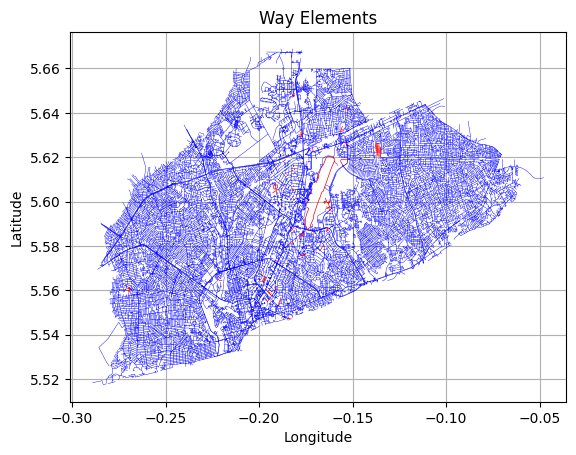

max latitude:  5.6688204
min latitude:  5.517379
max longitude:  -0.0478774
min longitude: -0.2889381


In [4]:
with open('data/accra_road.json') as file:
    data = json.load(file)

# 提取"way"元素的坐标
ways = data['elements']
max_lat = -100
max_lon = -100
min_lat = 100
min_lon = 100

for way in ways:
    if way['type'] == 'way' and 'tags' in way and 'highway' in way['tags'] and way['tags']['highway'] in ['residential','service','unclassified','primary', 'trunk', 'secondary', 'tertiary']:
        node_ids = way['nodes']
        #Get the coordinates of each point in each road segment: (lon, lat)
        coordinates = [(way['geometry'][node_index]['lon'], way['geometry'][node_index]['lat']) for node_index, node_id in enumerate(node_ids)]
        
        #Get the bounding box that contain all road segments, this is for cutting the elevation data to the size of the road network
        min_lat = min(way['bounds']['minlat'], min_lat)
        min_lon = min(way['bounds']['minlon'], min_lon)
        max_lat = max(way['bounds']['maxlat'], max_lat)
        max_lon = max(way['bounds']['maxlon'], max_lon)
        
        x_values, y_values = zip(*coordinates)
        if 'tags' in way and 'access' in way['tags'] and way['tags']['access']=='private':
            plt.plot(x_values, y_values, 'r-', linewidth = 0.5)
        else:
            plt.plot(x_values, y_values, 'b-', linewidth = 0.3)

# 设置图表属性
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Way Elements')
plt.grid(True)
plt.show()

print('max latitude: ', max_lat)
print('min latitude: ', min_lat)
print('max longitude: ', max_lon)
print('min longitude:', min_lon)


# Analyze the elevation data

2560 3428 1192 1737


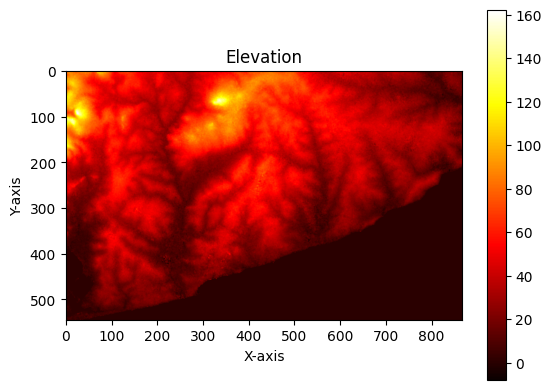

In [5]:
# The boundary lat, lon of the original elevation data
N_bound = 6
S_bound = 5
W_bound = -1
E_bound = 0

pixel_number = len(ele_info)
min_pixel_lat = int(pixel_number - (max_lat - S_bound)/(N_bound - S_bound)*pixel_number)
max_pixel_lat = int(pixel_number - (min_lat - S_bound)/(N_bound - S_bound)*pixel_number)
max_pixel_lon = int((max_lon - W_bound)/(E_bound - W_bound)*pixel_number)
min_pixel_lon = int((min_lon - W_bound)/(E_bound - W_bound)*pixel_number)

print(min_pixel_lon, max_pixel_lon, min_pixel_lat, max_pixel_lat)

ele_info_resize = ele_info[min_pixel_lat:max_pixel_lat,min_pixel_lon:max_pixel_lon]

plt.imshow(ele_info_resize, cmap='hot')  
plt.colorbar()  
plt.title('Elevation')  
plt.xlabel('X-axis')  
plt.ylabel('Y-axis')  

plt.show()

# Integrate the 2D road and elevation into 3D road

In [6]:
utm_converter = pyproj.Proj(proj='utm', zone=30, ellps='WGS84')

left_bound, up_bound = utm_converter(W_bound, N_bound)
right_bound, down_bound = utm_converter(E_bound, S_bound)
pixel_length_lat = (up_bound - down_bound) / pixel_number
pixel_length_lon = (right_bound - left_bound) / pixel_number

# 从JSON文件中加载数据
with open('data/accra_road.json') as file:
    data = json.load(file)

# 提取"way"元素的坐标
ways = data['elements']

min_i = 10000
max_i = 0
min_j = 10000
max_j = 0

for way in ways:
    if way['type'] == 'way' and 'tags' in way and 'highway' in way['tags'] and way['tags']['highway'] in ['residential','service','unclassified','primary', 'trunk', 'secondary', 'tertiary']:
        node_ids = way['nodes']
        #Get the coordinates of each point in each road segment: (lon, lat)
        coordinates = [(way['geometry'][node_index]['lon'], way['geometry'][node_index]['lat']) for node_index, node_id in enumerate(node_ids)]
        x_values, y_values = zip(*coordinates)
        for node_index, node_id in enumerate(node_ids):
            easting, northing = utm_converter(x_values[node_index], y_values[node_index])
            #find the index of the elevation grid for this point
            i = int((easting - left_bound) // pixel_length_lon)
            j = int((up_bound - northing) // pixel_length_lat)
            
            min_i = min(min_i, i)
            min_j = min(min_j, j)
            max_i = max(max_i, i)
            max_j = max(max_j, j)

            #get the coordinate of the center of the grid
            x_grid = i*pixel_length_lon + pixel_length_lon/2 + left_bound
            y_grid = up_bound - (j*pixel_length_lat + pixel_length_lat/2)

            #Judge which part of the grid does the point exist on
            if easting > x_grid:
                delta_i = 1
            else:
                delta_i = -1
            if northing > y_grid:
                delta_j = -1
            else:
                delta_j = 1

            #calculate the distance of the point with the four grids surounding it.
            distance_A = np.sqrt((easting - ((i+delta_i)*pixel_length_lon + pixel_length_lon/2 + left_bound))**2 + (northing - (up_bound - ((j+delta_j)*pixel_length_lat + pixel_length_lat/2)))**2)
            distance_B = np.sqrt((easting - ((i)*pixel_length_lon + pixel_length_lon/2 + left_bound))**2 + (northing - (up_bound - ((j+delta_j)*pixel_length_lat + pixel_length_lat/2)))**2)
            distance_C = np.sqrt((easting - ((i+delta_i)*pixel_length_lon + pixel_length_lon/2 + left_bound))**2 + (northing - (up_bound - ((j)*pixel_length_lat + pixel_length_lat/2)))**2)
            distance_D = np.sqrt((easting-x_grid)**2 + (northing-y_grid)**2)
            
            weight_total = 1/distance_A + 1/distance_B + 1/distance_C + 1/distance_D
            
            elevation_cur = (
                            1/distance_A/weight_total * ele_info[j+delta_j][i+delta_i] +
                            1/distance_B/weight_total * ele_info[j+delta_j][i] +
                            1/distance_C/weight_total * ele_info[j][i+delta_i] +
                            1/distance_D/weight_total * ele_info[j][i]
                            )
            way['geometry'][node_index]['lon'] = easting
            way['geometry'][node_index]['lat'] = northing
            way['geometry'][node_index]['ele'] = elevation_cur
print(min_i, max_i, min_j, max_j)

max_ele = 0
min_ele = 100000
for way in ways:
    if way['type'] == 'way' and 'tags' in way and 'highway' in way['tags'] and way['tags']['highway'] in ['residential','service','unclassified','primary', 'trunk', 'secondary', 'tertiary']:
        node_ids = way['nodes']
        coordinates = [(way['geometry'][node_index]['lon'], way['geometry'][node_index]['lat'], way['geometry'][node_index]['ele']) for node_index, node_id in enumerate(node_ids)]
        for i in coordinates:
            max_ele = max(max_ele, i[2])
            min_ele = min(min_ele, i[2])
print(max_ele)
print(min_ele)

2555 3418 1184 1734
151.31423648332054
-1.0400309978463385


# Create network graph for 3D road

This is only the simple bidirectional graph, without considering the slope and the oneway road.

In [8]:
G = nx.Graph()
for way in ways:
    if way['type'] == 'way' and 'tags' in way and 'highway' in way['tags'] and way['tags']['highway'] in ['residential','service','unclassified','primary', 'trunk', 'secondary', 'tertiary']:
        node_ids = way['nodes']
        #Get the coordinates of each point in each road segment: (lon, lat)
        coordinates = [(way['geometry'][node_index]['lon'], way['geometry'][node_index]['lat'], way['geometry'][node_index]['ele']) for node_index, node_id in enumerate(node_ids)]
        x_values, y_values, z_values = zip(*coordinates)
        for node_index, node_id in enumerate(node_ids):
            if node_index == len(node_ids)-1:
                nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')
                continue
            else:
                G.add_edges_from([(node_id, node_ids[node_index+1])], distance = np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2 + (z_values[node_index]-z_values[node_index+1])**2)) 
                nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')

                    

In [9]:
def get_closest_point(G,x,y):
    min_distance = float('inf')
    target = None
    for (p,c) in G.nodes(data=True):
        if ((x-c['coordinate'][0])**2 + (y-c['coordinate'][1])**2) < min_distance:
            min_distance = (x-c['coordinate'][0])**2 + (y-c['coordinate'][1])**2
            target = p
    return target

a = get_closest_point(G,813310, 620699)
print(a)

4448539604


In [10]:
kotoka_airport = (813329.05, 620518.36)
uni_ghana = (811795.639, 625324.503)

kotoka_airport = get_closest_point(G, kotoka_airport[0], kotoka_airport[1])
uni_ghana = get_closest_point(G, uni_ghana[0], uni_ghana[1])
print(kotoka_airport)
print(uni_ghana)

path = nx.shortest_path(G, source=kotoka_airport, target=uni_ghana, weight='distance')
path_distance = nx.shortest_path_length(G, source=kotoka_airport, target=uni_ghana, weight='distance')
print('You need to walk through these points.', path, '\n')
print('The total length of your path:', path_distance/1000,'km') #The path length from the google map is 7.3km

4033074333
5729193500
You need to walk through these points. [4033074333, 4033074356, 4448539593, 6013245886, 4033074371, 4033074385, 120356434, 120354609, 6013245888, 120354611, 6012501006, 120354612, 7111377648, 33538608, 6013221982, 5696738477, 33538609, 8874595626, 1984328530, 8874595624, 6011507721, 7115977282, 1984328531, 7116002885, 6011507722, 1984328532, 1984328533, 4448539608, 6011507723, 1984328534, 4448539609, 8874595656, 8874595642, 1984328535, 5696738431, 10185145533, 3480915985, 3078012673, 6011491008, 6011491028, 6011491029, 6011491005, 6011491006, 1984328537, 3078012676, 493762190, 4457112269, 6011477373, 4457112270, 1837599338, 33538924, 33538773, 1362216182, 6015581422, 493756891, 6015581420, 6011526790, 6011518211, 8835908774, 6011518210, 1837599342, 6011697082, 6013393103, 4419677079, 4419677091, 6015581424, 6013003387, 493774553, 6015581426, 5808269823, 493756527, 6015581429, 1837609878, 1424638699, 6080967814, 6010732116, 6013294879, 6010732117, 6013003386, 63014

In [12]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [31]:
def weight_matrix(G, point_list):
    n = len(point_list)
    
    new_list = [None]*n
    for index, point in enumerate(point_list):
        new_list[index] = get_closest_point(G, point[0], point[1])
    
    ans = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            else:
                ans[i, j] = nx.shortest_path_length(G, source=new_list[i], target=new_list[j], weight='distance')
    return ans

kotoka_airport = (813329.05, 620518.36)
uni_ghana = (811795.639, 625324.503)
random_position_1 = (814795.639, 635324.503)
random_position_2 = (813929.05, 620018.36)
a = weight_matrix(G, [kotoka_airport, uni_ghana, random_position_1, random_position_2])

In [32]:
a

array([[    0.        ,  5938.83472956,  8181.187619  ,  4335.17419549],
       [ 5938.83472956,     0.        ,  2818.7781113 ,  8535.40428511],
       [ 8181.187619  ,  2818.7781113 ,     0.        , 10682.27794263],
       [ 4335.17419549,  8535.40428511, 10682.27794263,     0.        ]])

# Create Directed Graph

In [56]:
G = nx.DiGraph()
for way in ways:
    if way['type'] == 'way' and 'tags' in way and 'highway' in way['tags'] and way['tags']['highway'] in ['residential','service','unclassified','primary', 'trunk', 'secondary', 'tertiary']:
        node_ids = way['nodes']
        #Get the coordinates of each point in each road segment: (lon, lat)
        coordinates = [(way['geometry'][node_index]['lon'], way['geometry'][node_index]['lat'], way['geometry'][node_index]['ele']) for node_index, node_id in enumerate(node_ids)]
        x_values, y_values, z_values = zip(*coordinates)
        if 'tags' in way and 'oneway' in way['tags'] and way['tags']['oneway'] == 'yes':
            #create one way road
            for node_index, node_id in enumerate(node_ids):
                if node_index == len(node_ids)-1:
                    nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')
                    continue
                else:
                    G.add_edges_from([(node_id, node_ids[node_index+1])], 
                                     distance = np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2 + (z_values[node_index]-z_values[node_index+1])**2),
                                     slope = (z_values[node_index]-z_values[node_index+1])/ np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2)) 
                    nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')
        else:
            #create bidirectional road, by creating two edge for the road segment in different direction.
            for node_index, node_id in enumerate(node_ids):
                if node_index == len(node_ids)-1:
                    nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')
                    continue
                else:
                    G.add_edges_from([(node_id, node_ids[node_index+1])], 
                                     distance = np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2 + (z_values[node_index]-z_values[node_index+1])**2),
                                     slope = (z_values[node_index]-z_values[node_index+1])/ np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2)) 
                    nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')
            for node_index, node_id in enumerate(reversed(node_ids)):
                x_values = list(reversed(x_values))
                y_values = list(reversed(y_values))
                z_values = list(reversed(z_values))
                if node_index == len(node_ids)-1:
                    nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')
                    continue
                else:
                    G.add_edges_from([(node_id, node_ids[node_index+1])], 
                                     distance = np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2 + (z_values[node_index]-z_values[node_index+1])**2),
                                     slope = (z_values[node_index]-z_values[node_index+1])/ np.sqrt((x_values[node_index]-x_values[node_index+1])**2 + (y_values[node_index]-y_values[node_index+1])**2)) 
                    nx.set_node_attributes(G, {node_id:(x_values[node_index], y_values[node_index], z_values[node_index])}, 'coordinate')

In [57]:
kotoka_airport = (813329.05, 620518.36)
uni_ghana = (811795.639, 625324.503)

kotoka_airport = get_closest_point(G, kotoka_airport[0], kotoka_airport[1])
uni_ghana = get_closest_point(G, uni_ghana[0], uni_ghana[1])
print(kotoka_airport)
print(uni_ghana)

path = nx.shortest_path(G, source=kotoka_airport, target=uni_ghana, weight='distance')
path_distance = nx.shortest_path_length(G, source=kotoka_airport, target=uni_ghana, weight='distance')
print('You need to walk through these points.', path, '\n')
print('The total length of your path:', path_distance/1000,'km') #The path length from the google map is 7.3km

4033074333
5729193500
You need to walk through these points. [4033074333, 4033074356, 4448539593, 6013245886, 4033074371, 4033074385, 120356434, 120356423, 120356445, 4448539605, 30729947, 4448539607, 30729938, 4448539606, 30729928, 6010689940, 4033074389, 5889753552, 4033074352, 6010689941, 6010689942, 30729957, 30729968, 4448539592, 1400185195, 4448539590, 30729984, 4448539288, 30729971, 30729959, 4448533260, 1400185191, 4448533262, 4448533263, 1400185193, 1837599307, 4448533257, 30729967, 6010689963, 1119305801, 8809482089, 2123756557, 5889752163, 1119305835, 6012943961, 6012943960, 6013273057, 6015581417, 1837599312, 5201287033, 4448521556, 6011526788, 1837599326, 1837599329, 1837599331, 1362216182, 6015581422, 493756891, 6015581420, 6011526790, 6011518211, 8835908774, 6011518210, 1837599342, 6011697082, 6013393103, 4419677079, 4419677091, 6015581424, 6013003387, 493774553, 6015581426, 5808269823, 493756527, 6015581429, 1837609878, 1424638699, 6080967814, 6010732116, 6013294879, 60

In [58]:
node1_id = 4448539599
node2_id = 30729951
if G.has_edge(node1_id, node2_id):
    edge = G[node1_id][node2_id]
    attributes = edge.items()
    for attr, value in attributes:
        print(attr, ":", value)
else:
    print("No edge found between the given nodes.")

distance : 3.4819408997995334
slope : 0.015233799158254293


In [59]:
node1_id = 30729951
node2_id = 4448539599
if G.has_edge(node1_id, node2_id):
    edge = G[node1_id][node2_id]
    attributes = edge.items()
    for attr, value in attributes:
        print(attr, ":", value)
else:
    print("No edge found between the given nodes.")

distance : 3.4819408997995334
slope : -0.015233799158254293
